## **Can you predict who in Africa is most likely to have a bank account?**

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler ,OneHotEncoder,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from feature_engine import encoding, outliers, imputation, selection
from sklearn.metrics import accuracy_score
from sklearn import model_selection, pipeline, metrics, ensemble, linear_model, neighbors, naive_bayes, svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# import tensorflow as tf
import xgboost
from lightgbm import LGBMClassifier
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

### **Importing Dataset**

In [ ]:
train_df= pd.read_csv('./Train.csv')
test_df=pd.read_csv('./Test.csv')

In [ ]:
train_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


### **check summary statistics of the data**

In [ ]:
train_df.shape

(23524, 13)

In [ ]:
test_df.shape


(10086, 12)

In [ ]:
train_df.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [ ]:
train_df.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

In [ ]:
train_df['bank_account'].value_counts()

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

### **Data Cleansing**

In [ ]:
train_df[train_df.isnull().any(axis=1)]

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type


In [ ]:
test_df[test_df.isnull().any(axis=1)]

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type


#### drop duplicates

In [ ]:
class RemoveDuplicateRowsTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y= None): 
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        self.failed = X.loc[data.duplicated()]
        X_copy= data.drop_duplicates(keep='first')
        return X_copy



### Count Frequency 

In [ ]:
class CountFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        categorical_columns = X.select_dtypes(object).columns
        self.mapper_object = {}
        for column in categorical_columns:
            mapper = X[column].value_counts() / X[column].shape[0]
            self.mapper_object.update({f"{column}": mapper})
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column in self.mapper_object.keys():
            X_copy[column] = X_copy[column].map(self.mapper_object[column])
        return X_copy

### Drop Highly correlated features

In [ ]:
class DropHighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.highly_correlated_features = []

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
        self.highly_correlated_features = [column for column in upper.columns if any(upper[column] > self.threshold)]
        
        return self

    def transform(self, X):
        X_copy = X.drop(columns=self.highly_correlated_features, axis=1)
        return X_copy

#### High Cardinality Remover

In [ ]:
class HighCardinalityRemover(BaseEstimator, TransformerMixin): 
    def __init__(self, threshold:int = 10 ): 
        self.threshold = threshold

    def fit(self, X:pd.DataFrame, y= None): 
        self.features_to_drop_ = set()
        self.feature_names_in_ = X.columns
        categorical_features_ = X.select_dtypes(include=object).columns
        for feature in categorical_features_:
            if X[feature].nunique() > self.threshold:
                self.features_to_drop_.add(feature)
        return self     
    
    def transform(self, X:pd.DataFrame, y = None): 
        X_copy = X.copy()
        return X_copy.drop(columns = self.features_to_drop_, axis = 1)


In [ ]:
class ConvertInt_to_Float(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    
    def transform(self,X,y=None):
        numerical_float= X.select_dtypes(include='int').columns
        X_copy = X.copy()
        for column in numerical_float:
            X_copy[column]=X_copy[column].astype(float)
            return X_copy
        

### Scaling Transof

In [ ]:
class StandardScalerTransform(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_scale: list = None):
        self.features_to_scale = features_to_scale

    def fit(self, X: pd.DataFrame, y=None):
        self.feature_names_in_ = X.columns.tolist()
        if self.features_to_scale is None:
            self.features_to_scale = X.select_dtypes("number").columns
        self.mean_ = X[self.features_to_scale].mean()
        self.std_ = X[self.features_to_scale].std()
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X_copy = X.copy()
        X_copy[self.features_to_scale] = (
            X[self.features_to_scale] - self.mean_
        ) / self.std_
        return X_copy

### Normalization (MinMaxScaling)

In [ ]:
class MinMaxScalerTransform(BaseEstimator,TransformerMixin):
    def _init__(self):
        pass 
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X_copy=X.copy()
        selected_column=X_copy.select_dtypes('number')
        X_copy= (selected_column-selected_column.min())/(selected_column.max()-selected_column.min())
        return X_copy

####  **Data Visualization**

In [ ]:
map_f={'Yes':1,'No':0}
train_df['bank_account']=train_df['bank_account'].map(map_f)

In [ ]:
train_df['bank_account']=train_df['bank_account'].astype('float64')

#### **fit the model**

In [ ]:
X= train_df.drop('bank_account',axis=1)
y=train_df['bank_account']

In [ ]:
xtrain, xtest, ytrain, ytest= model_selection.train_test_split(X, y, test_size=0.15, random_state=42)
display(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(19995, 12)

(3529, 12)

(19995,)

(3529,)

In [ ]:
import lightgbm ,tree

In [ ]:
models = {
    "random_forest": ensemble.RandomForestClassifier(),
    "adaboost": ensemble.AdaBoostClassifier(),
    "extra_trees": ensemble.ExtraTreesClassifier(),
    "gradient_boosting": ensemble.GradientBoostingClassifier(),
    "logistic_regression": linear_model.LogisticRegression(),
    "k_nearest_neighbors": neighbors.KNeighborsClassifier(n_neighbors=59,metric='euclidean'),
    "support_vector_machine": svm.SVC(),
    "xgboost": xgboost.XGBClassifier(),
    'ligbht': lightgbm.LGBMClassifier(),
    'quadratic':QuadraticDiscriminantAnalysis(),
    'catboost':CatBoostClassifier()
}

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
param_grid = {
    'learning_rate': uniform(0.01, 0.3),  
    'n_estimators': randint(50, 200),    
    'max_depth': randint(3, 10),           
    'min_samples_split': randint(2, 20),   
    'min_samples_leaf': randint(1, 20),    
    'subsample': uniform(0.6, 0.4)        
}

In [ ]:

transform_pipeline = Pipeline(steps=[
    ('drop_duplicates', RemoveDuplicateRowsTransformer()),
    ('count_frequency', CountFrequencyEncoder()),
    ('high_cardinality', HighCardinalityRemover(threshold=10)),
       ('impute',SimpleImputer(strategy='mean')),
    #('drop_constant_features', VarianceThreshold(threshold=0)),
    ('scaler', MinMaxScaler()),
    #('model',models['ligbht'])
    ('random_search', model_selection.RandomizedSearchCV(
        estimator=models['gradient_boosting'], 
        param_distributions=param_grid,
        n_iter=100, cv=5,
        scoring='neg_mean_absolute_error',
        random_state=42))
    
])

In [ ]:
transform_pipeline.fit(xtrain,ytrain)

KeyboardInterrupt: 

In [ ]:
#transform_pipeline.named_steps['random_search'].best_params_

In [ ]:
y_pred=transform_pipeline.predict(xtest)
#y_pred= (y_pred>0.5)


In [ ]:
def evaluation(ytest, ypred):
    return {
        "accuracy": metrics.mean_absolute_error(ytest, ypred),
        #"precision": metrics.precision_score(ytest, ypred),
        #'auc':metrics.roc_auc_score(ytest,ypred),
        #"f1_score": metrics.f1_score(ytest, ypred),
    }

In [ ]:

evaluation(ytest, y_pred)

{'accuracy': 0.10824596202890337}

Adaboost :0.1141966562765656,

extraTreee: 0.1379994332672145,

GradientBoosting:0.10909606120714083,
logistic_regre:0.12354774723717767,

k-nearest :0.1212808160952111,

sv: 0.11646358741853216,
xgboost:0.11221309152734486,
lght:0.10824596202890337,
quadaratic:0.15811844715216775,
caboost:0.11334655709832814





### **Feature Importances**

In [ ]:
best_estimator=transform_pipeline.named_steps['model'].best_estimator_
best_estimator.feature_importances_

AttributeError: 'XGBClassifier' object has no attribute 'best_estimator_'

In [ ]:
transform_pipeline.named_steps["random_search"].feature_names_in_,

(array(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
        'household_size', 'age_of_respondent', 'gender_of_respondent',
        'relationship_with_head', 'marital_status', 'education_level',
        'job_type'], dtype=object),)

In [ ]:
feature_importance = pd.DataFrame(best_estimator.feature_importances_,
                                 index= transform_pipeline.named_steps["random_search"].feature_names_in_,
                                 columns= ['feature_importance']).sort_values(by='feature_importance',ascending=False)

KeyError: 'random_search'

In [ ]:
feature_importance

,feature_importance
education_level,0.404556
job_type,0.134084
age_of_respondent,0.098165
country,0.097095
location_type,0.087919
cellphone_access,0.063738
marital_status,0.029648
household_size,0.027616
gender_of_respondent,0.021916
relationship_with_head,0.019772


<Axes: >

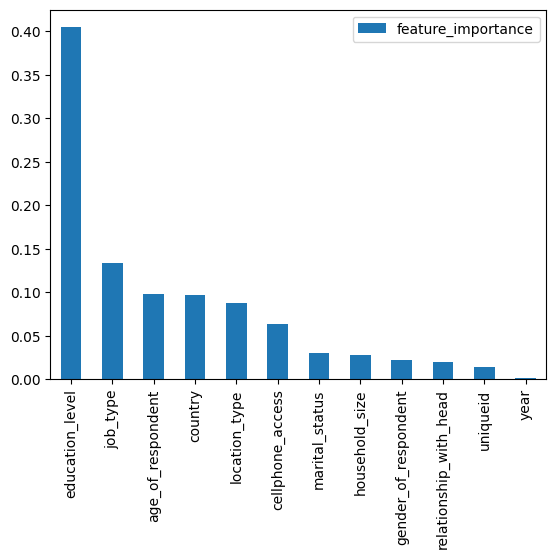

In [ ]:
feature_importance.plot(kind='bar')

In [ ]:
from sklearn.pipeline import FeatureUnion

#### hypertuning 

In [ ]:
ypred_result = transform_pipeline.predict(test_df)
ypred_result           

array([1., 1., 0., ..., 0., 0., 0.])

In [ ]:
test_df['bank_account']=ypred_result


In [ ]:
submission = pd.DataFrame({"uniqueid": test_df["uniqueid"] + " x " + test_df["country"],
                           "bank_account": test_df.bank_account})

In [ ]:
submission.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1.0
1,uniqueid_6060 x Kenya,1.0
2,uniqueid_6065 x Kenya,0.0
3,uniqueid_6072 x Kenya,0.0
4,uniqueid_6073 x Kenya,0.0


In [ ]:
submission.to_csv('mistakes.csv',index=False)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Implement cross vaidation